# **TUBES DL**

## **KELOMPOK 22 CNN-LSTM**

VENI ZAHARA KARTIKA_121450075

YOSIA ADWILY NAINGGOLAN_121450063

M. RIZKI ALFAINA_121140228

TRI MURNIYANINGSIH_121450038

IMA ALIFAH IZATI ZALFA_121450140

ANITA RAHMA PRAMODA CAHYANI_121450154

## **Resample**

In [1]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
import shutil
import os
import random
import math
import pandas as pd
import matplotlib.image as img
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
# Path data
train_folder = '/kaggle/input/20bn-jester/Train'
val_folder = '/kaggle/input/20bn-jester/Validation'
train_csv = '/kaggle/input/20bn-jester/Train.csv'
val_csv = '/kaggle/input/20bn-jester/Validation.csv'

# Path output setelah resampling
resampled_train_folder = '/kaggle/working/Resampled/Train'
resampled_val_folder = '/kaggle/working/Resampled/Validation'
resampled_train_csv = '/kaggle/working/Resampled/Train.csv'
resampled_val_csv = '/kaggle/working/Resampled/Validation.csv'

# Buat folder output jika belum ada
os.makedirs(resampled_train_folder, exist_ok=True)
os.makedirs(resampled_val_folder, exist_ok=True)

# Fungsi untuk penerjemahan manual
def translate_to_indonesian(label):
    translation_dict = {
        'Doing other things': 'Melakukan hal lain',
        'Pushing Two Fingers Away': 'Menjauhkan Dua Jari',
        'Drumming Fingers': 'Mengetuk Jari',
        'Sliding Two Fingers Down': 'Menggeser Dua Jari Ke Bawah',
        'Pushing Hand Away': 'Menjauhkan Tangan'
    }
    return translation_dict.get(label, label)

# Fungsi untuk resample data
def resample_data(folder, csv_path, output_folder, output_csv_path, selected_labels, samples_per_label):
    # Muat file CSV
    df = pd.read_csv(csv_path)

    # Filter hanya label yang dipilih
    df = df[df['label'].isin(selected_labels)]

    # Ambil sampel acak dari setiap label
    resampled_df = df.groupby('label').apply(lambda x: x.sample(min(samples_per_label, len(x)))).reset_index(drop=True)

    # Gantikan label bahasa Inggris dengan bahasa Indonesia
    resampled_df['label'] = resampled_df['label'].apply(translate_to_indonesian)

    # Salin folder ke lokasi baru
    for video_id in resampled_df['video_id']:
        # Pada data train dan validation, video_id berisi nama folder
        src_folder = os.path.join(folder, str(video_id))
        dst_folder = os.path.join(output_folder, str(video_id))
        if os.path.exists(src_folder):
            shutil.copytree(src_folder, dst_folder)

    # Simpan file CSV baru
    resampled_df.to_csv(output_csv_path, index=False)

# Resample data Train dan Validation
selected_labels = ['Doing other things', 'Pushing Two Fingers Away', 'Drumming Fingers', 
                   'Sliding Two Fingers Down', 'Pushing Hand Away']

samples_per_label_train = 1000  # 1000 folder per label untuk train
samples_per_label_val = 100    # 100 folder per label untuk validation

# Resampling untuk Train (1000 sample per label)
resample_data(train_folder, train_csv, resampled_train_folder, resampled_train_csv, selected_labels, samples_per_label_train)

# Resampling untuk Validation (100 sample per label)
resample_data(val_folder, val_csv, resampled_val_folder, resampled_val_csv, selected_labels, samples_per_label_val)

/tmp/ipykernel_30/697455803.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resampled_df = df.groupby('label').apply(lambda x: x.sample(min(samples_per_label, len(x)))).reset_index(drop=True)
/tmp/ipykernel_30/697455803.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resampled_df = df.groupby('label').apply(lambda x: x.sample(min(samples_per_label, len(x)))).reset_index(drop=True)


## **Preprocessing**

In [3]:
# Path data hasil resampling
TRAIN_DATA = '/kaggle/working/Resampled/Train.csv'
TRAIN_VIDS = '/kaggle/working/Resampled/Train'
VALID_DATA = '/kaggle/working/Resampled/Validation.csv'
VALID_VIDS = '/kaggle/working/Resampled/Validation'
TEST_DATA = '/kaggle/input/test-10/test10/test.csv'
TEST_VIDS = '/kaggle/input/test-10/test10/test'
FRAME_COUNT = 30

In [4]:
# Fungsi untuk membaca metadata
def read_metadata(file_path):
    data = pd.read_csv(file_path)
    data = data.set_index("video_id")["label"].to_dict()
    return data

In [5]:
# Fungsi untuk menyamakan jumlah frame
def get_unify_frames(video_path, hm_frames=FRAME_COUNT):
    frames = sorted(os.listdir(video_path))  # Urutkan nama frame
    frames_count = len(frames)
    if hm_frames > frames_count:
        frames += [frames[-1]] * (hm_frames - frames_count)  # Gandakan frame terakhir
    elif hm_frames < frames_count:
        frames = frames[:hm_frames]  # Ambil frame awal hingga jumlah yang diinginkan
    return frames

In [6]:
# Fungsi untuk resize frame
def resize_frame(frame_path):
    frame = img.imread(frame_path)
    frame = cv2.resize(frame, (64, 64))
    return frame

In [7]:
# Normalisasi data
def normalize(data):
    scaler = StandardScaler()
    scaled_images = scaler.fit_transform(data.reshape(-1, FRAME_COUNT * 64 * 64))
    return scaled_images.reshape(-1, FRAME_COUNT, 64, 64, 1)

In [8]:
# Fungsi untuk memuat frame video dan label (train & validation)
def load_video_frames(parent_dir_for_videos, labels, metadata):
    dirs = os.listdir(parent_dir_for_videos)
    new_frames = []  # Menyimpan frame video
    training_targets = []  # Menyimpan label
    for directory in dirs:
        video_path = os.path.join(parent_dir_for_videos, directory)
        if os.path.isdir(video_path):
            # Ambil frame
            frames = get_unify_frames(video_path)
            video_frames = [
                resize_frame(os.path.join(video_path, frame)) for frame in frames
            ]
            # Ubah ke grayscale
            video_frames = [
                cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) for frame in video_frames
            ]
            new_frames.append(video_frames)
            training_targets.append(labels.index(metadata[int(directory)]))

    # Normalisasi data
    new_frames = np.array(new_frames, dtype=np.float32)
    scaled_images = normalize(new_frames)
    return scaled_images, training_targets

In [9]:
# Fungsi untuk memuat frame video (test)
def load_test_frames(parent_dir_for_videos, frame_count=FRAME_COUNT):
    dirs = os.listdir(parent_dir_for_videos)
    test_frames = []  # Menyimpan frame video
    for directory in dirs:
        video_path = os.path.join(parent_dir_for_videos, directory)
        if os.path.isdir(video_path):
            # Ambil frame
            frames = get_unify_frames(video_path, hm_frames=frame_count)
            video_frames = [
                resize_frame(os.path.join(video_path, frame)) for frame in frames
            ]
            # Ubah ke grayscale
            video_frames = [
                cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) for frame in video_frames
            ]
            test_frames.append(video_frames)

    # Normalisasi data
    test_frames = np.array(test_frames, dtype=np.float32)
    scaled_images = normalize(test_frames)
    return scaled_images

In [10]:
# Baca metadata dan label
train_metadata = read_metadata(TRAIN_DATA)
valid_metadata = read_metadata(VALID_DATA)
test_metadata = read_metadata(TEST_DATA)
labels = list(set(train_metadata.values()))

# Muat data train dan validation
x_train, y_train = load_video_frames(TRAIN_VIDS, labels, train_metadata)
x_val, y_val = load_video_frames(VALID_VIDS, labels, valid_metadata)

# Muat data test
x_test = load_test_frames(TEST_VIDS)
y_test = [labels.index(test_metadata[int(directory)]) for directory in os.listdir(TEST_VIDS)]
y_test = np.array(y_test)

# Ubah ke numpy array
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)
x_test = np.array(x_test)

print("Data train:", x_train.shape, y_train.shape)
print("Data validation:", x_val.shape, y_val.shape)
print("Data test:", x_test.shape, y_test.shape)

Data train: (5000, 30, 64, 64, 1) (5000,)
Data validation: (500, 30, 64, 64, 1) (500,)
Data test: (10, 30, 64, 64, 1) (10,)


## **Model CNN-LSTM**

In [27]:
# Jumlah kelas berdasarkan label unik
NUM_CLASSES = len(labels)

# Definisi Model CNN + LSTM
class ConvLSTMModel(tf.keras.Model):
    def __init__(self):
        super(ConvLSTMModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', name="conv1")
        self.pool1 = tf.keras.layers.MaxPool3D(pool_size=(2, 2, 2))
        self.conv2 = tf.keras.layers.Conv3D(64, (3, 3, 3), activation='relu', name="conv2")
        self.pool2 = tf.keras.layers.MaxPool3D(pool_size=(2, 2, 2))
        self.convLSTM = tf.keras.layers.ConvLSTM2D(40, (3, 3), activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(128, activation='relu', name="dense1")
        self.out = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', name="output")

    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.convLSTM(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.out(x)

# Buat model
model_cnnlstm = ConvLSTMModel()

# Kompilasi model
model_cnnlstm.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

# Callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',         
    patience=2,                 
    restore_best_weights=True   
)

# Pelatihan model dengan Early Stopping
history1 = model_cnnlstm.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 123ms/step - accuracy: 0.1985 - loss: 1.6176 - val_accuracy: 0.2420 - val_loss: 1.5931
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - accuracy: 0.3378 - loss: 1.5276 - val_accuracy: 0.3680 - val_loss: 1.5935
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 103ms/step - accuracy: 0.6180 - loss: 1.0016 - val_accuracy: 0.6820 - val_loss: 0.8353
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - accuracy: 0.7726 - loss: 0.6053 - val_accuracy: 0.7740 - val_loss: 0.6200
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - accuracy: 0.8464 - loss: 0.4298 - val_accuracy: 0.7900 - val_loss: 0.5999
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - accuracy: 0.8788 - loss: 0.3346 - val_accuracy: 0.8180 - val_loss: 0.5836
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 102ms/step - accuracy: 0.9254 - loss: 0.2098 - val_accuracy: 0.8300 - val_loss: 0.5711
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 102ms/step - accuracy: 0.9486 - loss: 0.

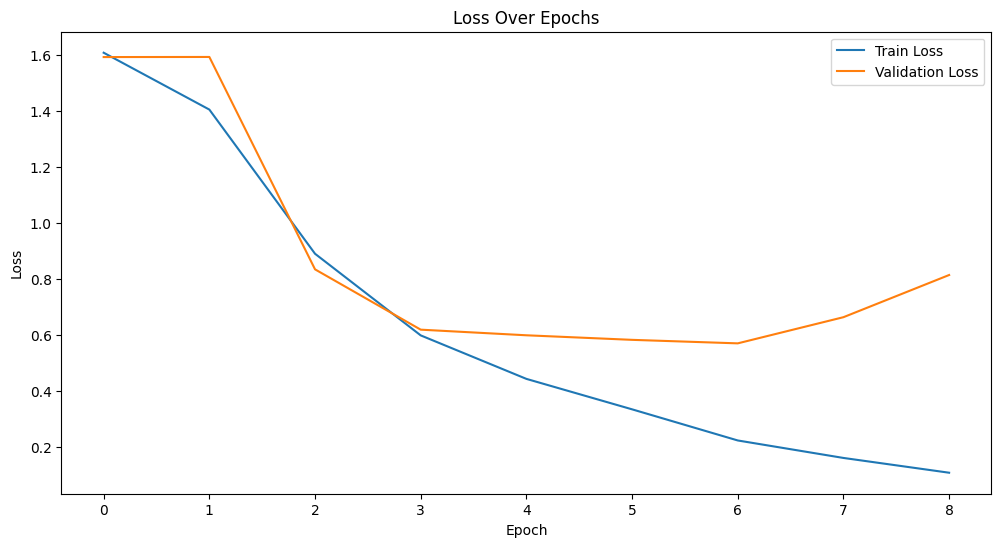

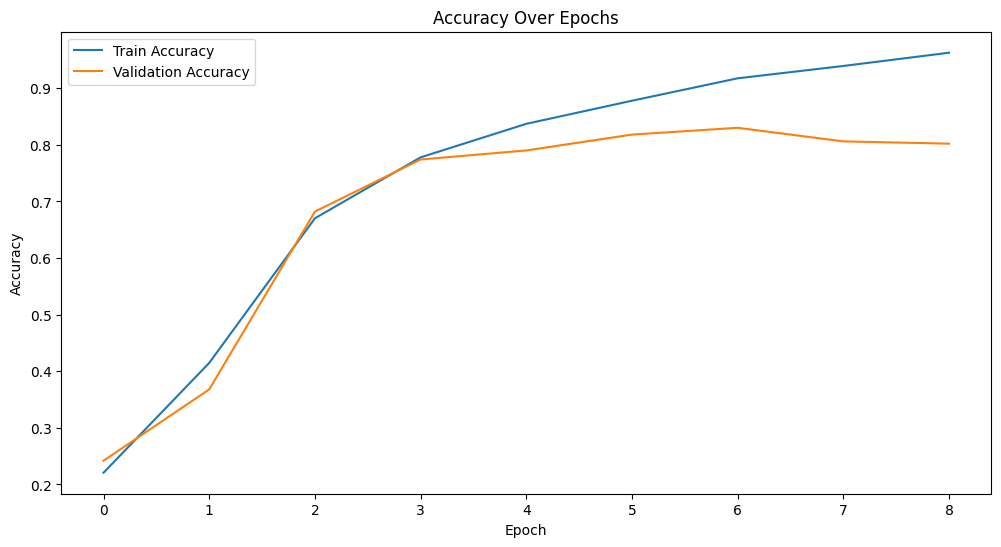

In [29]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


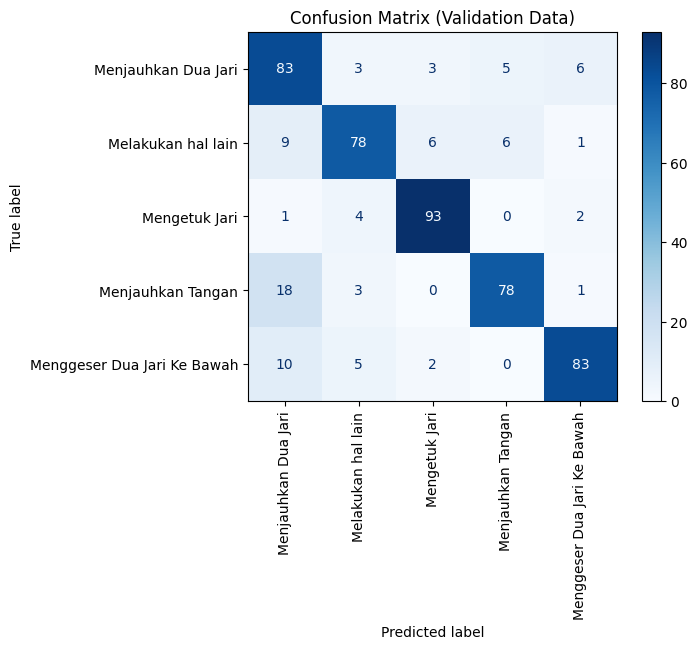


Classification Report:
                              precision    recall  f1-score   support

        Menjauhkan Dua Jari       0.69      0.83      0.75       100
         Melakukan hal lain       0.84      0.78      0.81       100
              Mengetuk Jari       0.89      0.93      0.91       100
          Menjauhkan Tangan       0.88      0.78      0.83       100
Menggeser Dua Jari Ke Bawah       0.89      0.83      0.86       100

                   accuracy                           0.83       500
                  macro avg       0.84      0.83      0.83       500
               weighted avg       0.84      0.83      0.83       500



In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

# Prediksi pada data validasi
y_pred = np.argmax(model_cnnlstm.predict(x_val), axis=-1)

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix (Validation Data)')
plt.show()

# Classification Report
class_report = classification_report(y_val, y_pred, target_names=labels)
print("\nClassification Report:\n", class_report)

In [32]:
# Evaluasi model pada data train
loss, accuracy = model_cnnlstm.evaluate(x_train, y_train, verbose=0)
print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy}")

Train Loss: 0.18560051918029785
Train Accuracy: 0.9404000043869019


In [33]:
# Evaluasi model pada data validation
val_loss, val_accuracy = model_cnnlstm.evaluate(x_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

Validation Loss: 0.5710840821266174
Validation Accuracy: 0.8299999833106995


## **Data Test CNN-LSTM**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


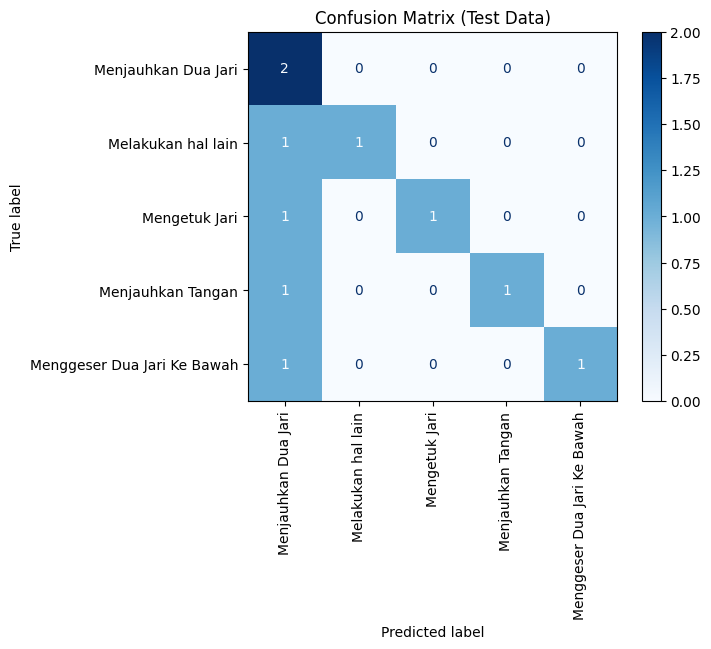


Classification Report (Test Data):
                              precision    recall  f1-score   support

        Menjauhkan Dua Jari       0.33      1.00      0.50         2
         Melakukan hal lain       1.00      0.50      0.67         2
              Mengetuk Jari       1.00      0.50      0.67         2
          Menjauhkan Tangan       1.00      0.50      0.67         2
Menggeser Dua Jari Ke Bawah       1.00      0.50      0.67         2

                   accuracy                           0.60        10
                  macro avg       0.87      0.60      0.63        10
               weighted avg       0.87      0.60      0.63        10

Test Loss: 0.8175352215766907
Test Accuracy: 0.6000000238418579
  video_id              predicted_label
0      109          Menjauhkan Dua Jari
1       20          Menjauhkan Dua Jari
2      233                Mengetuk Jari
3       79          Menjauhkan Dua Jari
4       85  Menggeser Dua Jari Ke Bawah
5        3          Menjauhkan Dua 

In [34]:
# Prediksi data test
predictions = model_cnnlstm.predict(x_test)

# Ambil label dengan probabilitas tertinggi
test_predicted_labels = np.argmax(predictions, axis=-1)

# Confusion Matrix untuk data test
test_cm = confusion_matrix(y_test, test_predicted_labels)
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=labels)
test_disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix (Test Data)')
plt.show()

# Classification Report untuk data test
test_class_report = classification_report(y_test, test_predicted_labels, target_names=labels)
print("\nClassification Report (Test Data):\n", test_class_report)

# Evaluasi model pada data test
test_loss, test_accuracy = model_cnnlstm.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Mengonversi hasil prediksi numerik menjadi label string
test_predicted_label_strings = [labels[label] for label in test_predicted_labels]

# Gabungkan video_id dengan prediksi label string
test_video_ids = [directory for directory in os.listdir(TEST_VIDS) if os.path.isdir(os.path.join(TEST_VIDS, directory))]
test_predicted_df = pd.DataFrame({'video_id': test_video_ids, 'predicted_label': test_predicted_label_strings})

# Tampilkan DataFrame hasil prediksi
print(test_predicted_df)

## **Model CNN-GRU**

In [35]:
# Jumlah kelas berdasarkan label unik
NUM_CLASSES = len(labels)

# Definisi Model CNN + GRU
class ConvGRUModel(tf.keras.Model):
    def __init__(self):
        super(ConvGRUModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', name="conv1")
        self.pool1 = tf.keras.layers.MaxPool3D(pool_size=(2, 2, 2))
        self.conv2 = tf.keras.layers.Conv3D(64, (3, 3, 3), activation='relu', name="conv2")
        self.pool2 = tf.keras.layers.MaxPool3D(pool_size=(2, 2, 2))
        
        # Reshape to match expected GRU input: (batch_size, time_steps, features)
        self.reshape = tf.keras.layers.Reshape((-1, 64 * 14 * 14))  # Adjust dimensions as needed
        
        self.gru = tf.keras.layers.GRU(128, return_sequences=False, activation='relu', name="gru")
        self.d1 = tf.keras.layers.Dense(128, activation='relu', name="dense1")
        self.out = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', name="output")

    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        
        # Reshape the tensor from (batch, depth, height, width, channels)
        # to (batch, timesteps, features) for GRU
        x = self.reshape(x)
        
        x = self.gru(x)
        x = self.d1(x)
        return self.out(x)
# Buat model
model_cnngru = ConvGRUModel()

# Kompilasi model
model_cnngru.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [36]:
from tensorflow.keras.callbacks import EarlyStopping

# Callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',         
    patience=2,                 
    restore_best_weights=True   
)

# Pelatihan model dengan Early Stopping
history2 = model_cnngru.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.2895 - loss: 1.5642 - val_accuracy: 0.6220 - val_loss: 1.0450
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - accuracy: 0.6277 - loss: 0.9660 - val_accuracy: 0.7220 - val_loss: 0.7359
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - accuracy: 0.7747 - loss: 0.6175 - val_accuracy: 0.7700 - val_loss: 0.6761
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.8541 - loss: 0.4069 - val_accuracy: 0.7620 - val_loss: 0.7107
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - accuracy: 0.8881 - loss: 0.3120 - val_accuracy: 0.8120 - val_loss: 0.6852


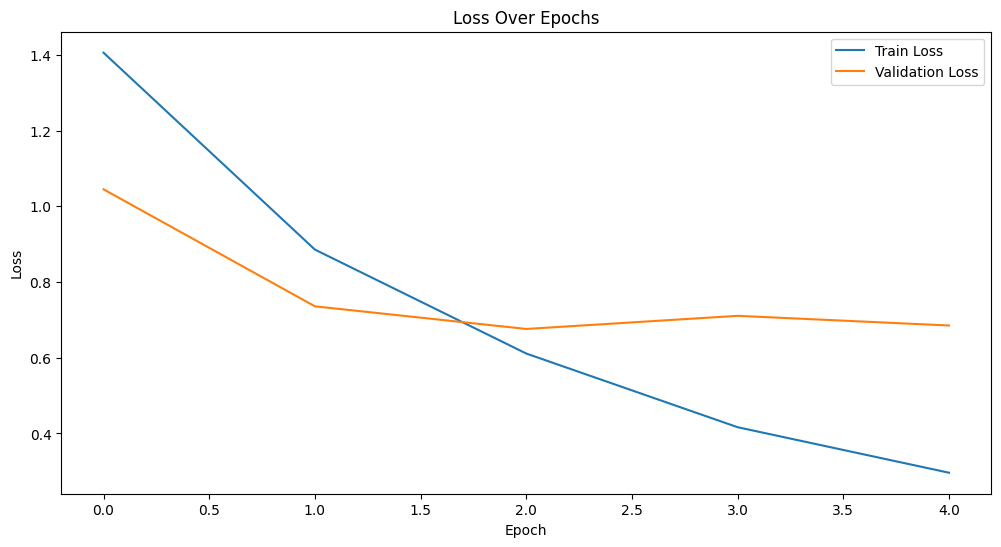

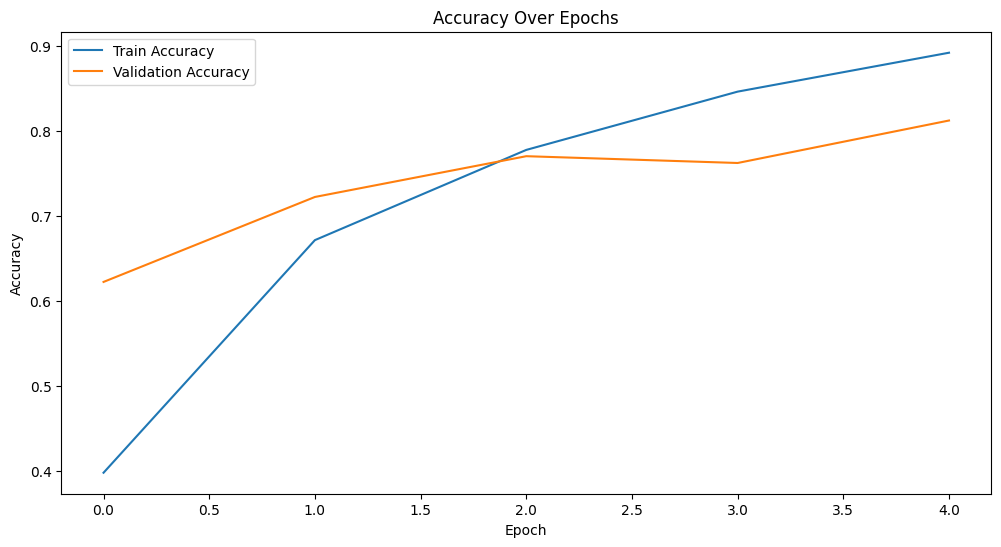

In [37]:
# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


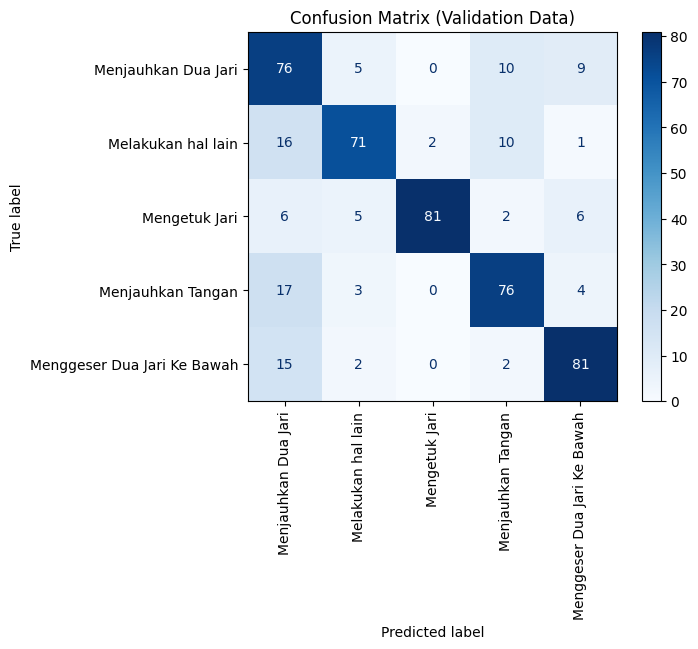


Classification Report:
                              precision    recall  f1-score   support

        Menjauhkan Dua Jari       0.58      0.76      0.66       100
         Melakukan hal lain       0.83      0.71      0.76       100
              Mengetuk Jari       0.98      0.81      0.89       100
          Menjauhkan Tangan       0.76      0.76      0.76       100
Menggeser Dua Jari Ke Bawah       0.80      0.81      0.81       100

                   accuracy                           0.77       500
                  macro avg       0.79      0.77      0.78       500
               weighted avg       0.79      0.77      0.78       500



In [38]:
# Prediksi pada data validasi
y_pred = np.argmax(model_cnngru.predict(x_val), axis=-1)

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix (Validation Data)')
plt.show()

# Classification Report
class_report = classification_report(y_val, y_pred, target_names=labels)
print("\nClassification Report:\n", class_report)

In [39]:
# Evaluasi model pada data train
loss, accuracy = model_cnngru.evaluate(x_train, y_train, verbose=0)
print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy}")

Train Loss: 0.45475971698760986
Train Accuracy: 0.8389999866485596


In [40]:
# Evaluasi model pada data validasi
val_loss, val_accuracy = model_cnngru.evaluate(x_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

Validation Loss: 0.6760545372962952
Validation Accuracy: 0.7699999809265137


## **Data Test CNN-GRU**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


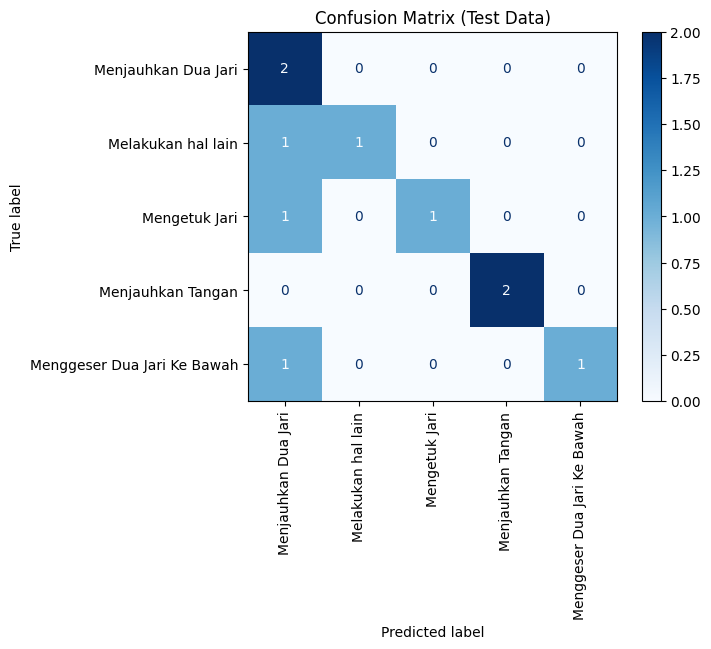


Classification Report (Test Data):
                              precision    recall  f1-score   support

        Menjauhkan Dua Jari       0.40      1.00      0.57         2
         Melakukan hal lain       1.00      0.50      0.67         2
              Mengetuk Jari       1.00      0.50      0.67         2
          Menjauhkan Tangan       1.00      1.00      1.00         2
Menggeser Dua Jari Ke Bawah       1.00      0.50      0.67         2

                   accuracy                           0.70        10
                  macro avg       0.88      0.70      0.71        10
               weighted avg       0.88      0.70      0.71        10

Test Loss: 0.9314139485359192
Test Accuracy: 0.699999988079071
  video_id              predicted_label
0      109          Menjauhkan Dua Jari
1       20          Menjauhkan Dua Jari
2      233                Mengetuk Jari
3       79            Menjauhkan Tangan
4       85          Menjauhkan Dua Jari
5        3          Menjauhkan Dua J

In [41]:
# Prediksi data test
predictions = model_cnngru.predict(x_test)

# Ambil label dengan probabilitas tertinggi
test_predicted_labels = np.argmax(predictions, axis=-1)

# Confusion Matrix untuk data test
test_cm = confusion_matrix(y_test, test_predicted_labels)
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=labels)
test_disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix (Test Data)')
plt.show()

# Classification Report untuk data test
test_class_report = classification_report(y_test, test_predicted_labels, target_names=labels)
print("\nClassification Report (Test Data):\n", test_class_report)

# Evaluasi model pada data test
test_loss, test_accuracy = model_cnngru.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Mengonversi hasil prediksi numerik menjadi label string
test_predicted_label_strings = [labels[label] for label in test_predicted_labels]

# Gabungkan video_id dengan prediksi label string
test_video_ids = [directory for directory in os.listdir(TEST_VIDS) if os.path.isdir(os.path.join(TEST_VIDS, directory))]
test_predicted_df = pd.DataFrame({'video_id': test_video_ids, 'predicted_label': test_predicted_label_strings})

# Tampilkan DataFrame hasil prediksi
print(test_predicted_df)

## **Save Model**

In [42]:
model_cnnlstm.save('model_cnnlstm.h5')

In [43]:
model_cnnlstm.save('model_cnngru.h5')